In [ ]:
!pip install seaborn scikit-image

In [11]:
import sys
sys.path.append("/home/eltayeb/phyre_proj/codebase/phyre_agents/agents")

import phyre
from torch import nn
import torch
import matplotlib.pyplot as plt 
import numpy as np
#from sklearn.manifold import TSNE
import seaborn as sns
import os 

from visualize_policy import visualize_policy as vis_policy
import visualize_policy as vp
from neural_agent import build_model, get_latest_checkpoint, eval_actions, load_agent_from_folder
from nets import ResNetFilmAction
from psim import ParallelPhyreSimulator
#from min_dists import batched_min_dist

import weakref


In [12]:
import pickle
smooth_initial_scenes = pickle.load(open("/home/eltayeb/phyre_proj/misc/phyre_rendered.bin", "rb"))
#sim = phyre.initialize_simulator(["00022:660", "00022:430"], "ball")
smooth_initial_scenes = {"00022:660": phyre.observations_to_uint8_rgb(sim.initial_scenes[0]),
        "00022:430": phyre.observations_to_uint8_rgb(sim.initial_scenes[1])}

plt.imshow(data["00022:660"])

NameError: name 'sim' is not defined

In [13]:
#from PIL import Image, ImageOps, ImageDraw
from visualize_policy import *

def get_policy_overlay(
    actions,
    scores,
    threshold=0.5,
    r=5,
    vary_intensity=False,
    text=None,
    sigmoid=True,
    rescale=True,
    end_color=None,
    end_color_offset=0,
    end_color_scale=1):

    canvas = Image.new('RGB', (phyre.SCENE_HEIGHT, phyre.SCENE_WIDTH))
    draw = ImageDraw.Draw(canvas)
    if vary_intensity:
        rank = np.argsort(scores)
        scores = scores[rank]
        actions = actions[rank]
        if sigmoid:
            intensity_factors = 1 / (1 + np.exp(- 0.3 * scores))
        else:
            if rescale:
                intensity_factors = (scores - scores.min()) / (scores.max() - scores.min())
            else:
                intensity_factors = scores
    for i, (action, score) in enumerate(zip(actions, scores)):
        if score > threshold:

            if len(action) == 3:
                centers = [action[:2]]
                colors = [functools.partial(lab_color, end_color=end_color, scale=end_color_scale, offset=end_color_offset)]#[lambda x: (0, x, x)]
            else:
                centers = [action[:2], action[3:5]]
                centers.sort(key=lambda x: x[0])
                colors = [lambda x: (0, x, x), lambda x:(0, x // 3 , x)]

            for point, color in zip(centers, colors):
                scaled_point = point * phyre.SCENE_WIDTH
                upper_corner = scaled_point + r / SQRT2
                lower_corner = scaled_point - r / SQRT2
                upper_corner = int(upper_corner[0]), int(upper_corner[1])
                lower_corner = int(lower_corner[0]), int(lower_corner[1])

                if vary_intensity:
                    intensity = intensity_factors[i]# int(255 * intensity_factors[i])
                else:
                    intensity = 1 
                draw.ellipse([lower_corner, upper_corner], fill=color(intensity))
    
    canvas = ImageOps.flip(canvas)
    draw = ImageDraw.Draw(canvas)
    if text is not None:
        draw.text((phyre.SCENE_WIDTH * 3 // 5, phyre.SCENE_HEIGHT // 7), text, align="left")
    
    return np.array(canvas).astype(np.uint8)

def combine_visualizations(underlying, overlay):
    visualization = (underlying - overlay).clip(0, 255)
    original_pixels = (underlying != 255).any(axis=2)
    visualization[original_pixels] = underlying[original_pixels]
    return visualization

In [14]:
baseline_dir= r"/home/eltayeb/phyre_proj/misc/baseline"
ours_dir = r"/home/eltayeb/phyre_proj/misc/ours"

In [15]:
DEVICE = "cpu"
def load_agent_from_folder(agent_folder: str, dp):
    last_checkpoint = get_latest_checkpoint(agent_folder)
    assert last_checkpoint is not None, agent_folder
    last_checkpoint = torch.load(last_checkpoint, map_location=torch.device("cpu"))
    model = build_model(**last_checkpoint['model_kwargs'])
    if dp:
        model = nn.DataParallel(model)
    print(model.load_state_dict(last_checkpoint['model'], strict=False))
    model = model.module
    model.to(DEVICE)
    
    return model

class Identity(nn.Module):
    def forward(self, x):
        return x
    
def remove_embeddor(model):
    model.embeddor = Identity()

In [16]:
baseline = load_agent_from_folder(baseline_dir, 1)
ours = load_agent_from_folder(ours_dir, 1)

remove_embeddor(ours)
remove_embeddor(baseline)

<All keys matched successfully>
<All keys matched successfully>


In [17]:
def visualise_index(i, agent, sigmoid=False, threshold=0, argsort=None):
    global actions
    actions_to_plot = actions[data["simulation_statuses"][i, :n_actions]!=0]
    q_scores = eval_actions(agent, actions_to_plot, 256, sim.initial_scenes[i])
    if argsort is not None:
        ranks = np.argsort(-q_scores)[:argsort]
        actions_to_plot = actions_to_plot[ranks]
        q_scores = argsort - np.arange(argsort) 

    visualization = visualize_policy(sim, i, actions_to_plot, q_scores, threshold=threshold, vary_intensity=True, sigmoid=sigmoid)
    plt.imshow(visualization)

In [ ]:
# sigmoid = False
# threshold = -1000
# argsort = None
# for ind, id in enumerate(sim.task_ids):
#     plt.figure()
#     plt.gcf().suptitle(id)
#     plt.subplot(121)
#     plt.xlabel("Baseline")
#     visualise_index(ind, baseline, sigmoid, threshold, argsort=argsort)
#     plt.subplot(122)
#     plt.xlabel("Ours")
#     visualise_index(ind, ours, sigmoid, threshold, argsort)

In [18]:
def get_valid_actions(sim, cache, index, n_actions):
    task_id = sim.task_ids[index]
    valids = cache.get_sample([task_id])["simulation_statuses"].squeeze()[:n_actions] != 0
    n_total = valids.shape[0]
    valid_actions = cache.action_array[:n_total][valids]
    return valid_actions[:n_actions], np.arange(n_total)[valids][:n_actions]
    
def tsne_comparison(embeddings, names, color_by=None, n_points=None, perplexity=30):
    n = len(embeddings)
    if n_points is None:
        n_points = embeddings[0].shape[0]
    for i in range(n):
        plt.subplot(1, n, i + 1)
        reduced = TSNE(n_components=2, perplexity=perplexity).fit_transform(embeddings[i][:n_points])
        sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], 
                        hue=color_by[:n_points])
        plt.title(names[i])

def get_embeddings(observation, actions, *models):
    actions = torch.from_numpy(actions).to(DEVICE)
    observation = torch.from_numpy(observation).to(DEVICE).unsqueeze(0)
    with torch.no_grad():
        return [model(observation, actions, get_embeddings=True)[1].cpu().detach().numpy() for model in models]
    



# Generate embeddings

In [19]:
task_ids_ = ["00022:430", "00022:660"]
_sim = phyre.initialize_simulator(task_ids_, "ball")
imgs = []
cache = phyre.get_default_100k_cache("ball")

n_actions = 10_000
embeddings_cache = {}
action_inds_cache = {}
actions_cache = {}
for index, task_id in enumerate(task_ids_):
    print(task_id)
    actions_subset, action_indices = get_valid_actions(_sim, cache, index, n_actions)
    labels = cache.get_sample([_sim.task_ids[index]])["simulation_statuses"].squeeze()[action_indices]
    embeddings_cache[index] = get_embeddings(_sim.initial_scenes[index], actions_subset, ours, baseline)
    action_inds_cache[index] = action_indices
    actions_cache[index] = actions_subset
embeddings_cache.keys(), actions_cache[0].shape, embeddings_cache[0][0].shape

00022:430
00022:660


(dict_keys([0, 1]), (7389, 3), (7389, 512))

(4,) (7389,) 4
(7,) (7636,) 7


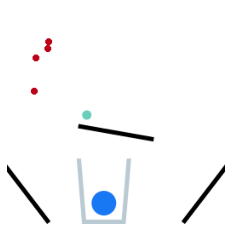

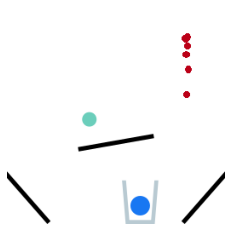

In [20]:
imgs = {}

for i, task_id in enumerate(task_ids_):
    valid_action_inds = action_inds_cache[i]
    valid_actions = actions_cache[i]
    valid_action_solved_mask = cache.get_sample([task_id])["simulation_statuses"][0, valid_action_inds] == 1
    solution_actions = valid_actions[valid_action_solved_mask]
    scores = np.ones(solution_actions.shape[0])
    print(scores.shape, valid_action_solved_mask.shape, valid_action_solved_mask.astype(int).sum())
    
    overlay = get_policy_overlay(solution_actions, scores, vary_intensity=False)
    #imgs[task_id] = overlay
    imgs[task_id] = combine_visualizations(smooth_initial_scenes[task_id], overlay)


import imageio
for task_id, img in imgs.items():
    plt.figure()
    plt.imshow(img, interpolation="antialiased")
    plt.axis("off")
   # imageio.imwrite(f"/checkpoint/ekahmed/{task_id.replace(':', '')}gt.png",img)


0 00022:660 ours
1 00022:430 ours
2 00022:660 baseline
3 00022:430 baseline
4
mkdir: cannot create directory ‘fig1’: File exists


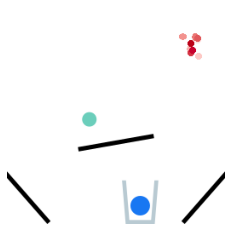

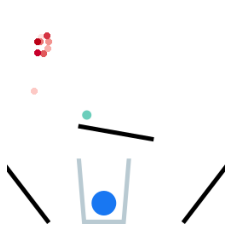

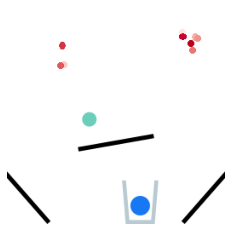

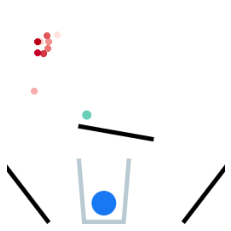

In [24]:
b_660_a= "0.84387,0.82982,0.97415;0.80667,0.85802,0.99763;0.25335,0.81824,0.98582;0.24668,0.72646,0.99181;0.84978,0.79770,0.98679;0.87649,0.85214,0.96488;0.86483,0.85733,0.95156;0.26016,0.73082,0.98130;0.80299,0.87932,0.93768;0.25308,0.80958,0.95032"
b_430_a="0.13936,0.83493,0.98440;0.13955,0.78348,0.99928;0.16672,0.77954,0.98994;0.18193,0.86179,0.94612;0.18850,0.80497,0.96733;0.19230,0.83744,0.94505;0.12653,0.61031,0.99591;0.15079,0.83595,0.93591;0.23148,0.86841,0.92646;0.22429,0.81598,0.98122"

ours_660_a = "0.84387,0.82982,0.97415;0.84978,0.79770,0.98679;0.84231,0.78459,0.98328;0.87649,0.85214,0.96488;0.86483,0.85733,0.95156;0.80667,0.85802,0.99763;0.83815,0.80281,0.96092;0.87958,0.76955,0.98162;0.87643,0.84320,0.95206;0.82184,0.79416,0.97258"
ours_430_a = "0.13936,0.83493,0.98440;0.13955,0.78348,0.99928;0.18193,0.86179,0.94612;0.16672,0.77954,0.98994;0.15079,0.83595,0.93591;0.19230,0.83744,0.94505;0.18850,0.80497,0.96733;0.12653,0.61031,0.99591;0.15745,0.85615,0.90957;0.13393,0.76053,0.93581"
actions_to_plot = [ours_660_a, ours_430_a, b_660_a, b_430_a]
task_ids_p = ["00022:660", "00022:430", "00022:660", "00022:430"]
models = ["ours", "ours", "baseline", "baseline"]
to_arr = lambda x: [list(map(float, i.split(","))) for i in x.split(";")]
actions_to_plot = [np.array(to_arr(str_)) for str_ in actions_to_plot]


imgs = {}

for i, (task_id,action_xys, model_name) in enumerate(zip(task_ids_p, actions_to_plot, models)):
    action_xys = action_xys
    print(i, task_id, model_name)
    scores = np.arange(len(action_xys)-1, -1, -1)

    
    overlay = get_policy_overlay(action_xys, scores, vary_intensity=True, sigmoid=False)
    imgs[(task_id, model_name)] = combine_visualizations(smooth_initial_scenes[task_id], overlay)

print(len(imgs))

import imageio
!mkdir fig1
for (task_id, model_name), img in imgs.items():
    plt.figure()
    plt.imshow(img, interpolation="antialiased")
    plt.axis("off")
    #plt.title(task_id + model_name)
    imageio.imwrite(f"fig1/{task_id.replace(':', '') + model_name}.png",img)

# Fancy new visualization

0.7552182 1.0
0.8755675 1.0
0.8198766 1.0
0.8780476 1.0000001


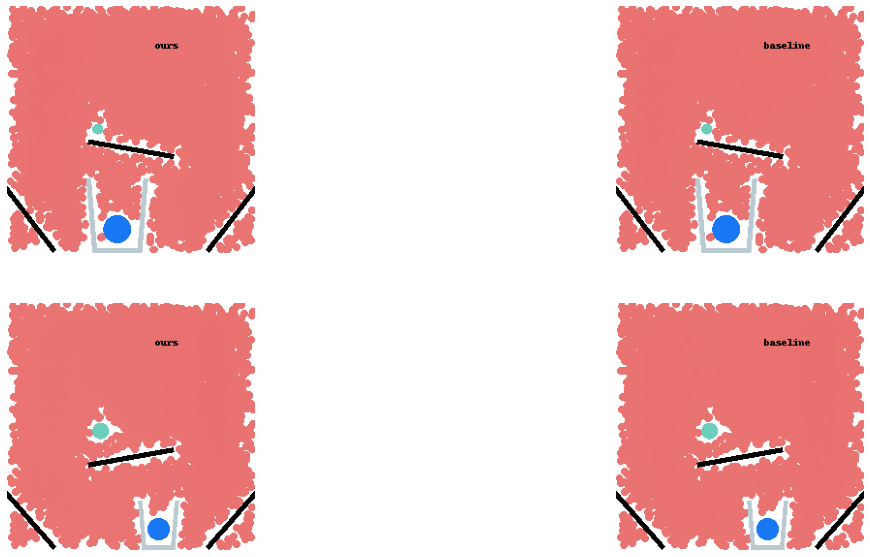

In [25]:
imgs = []
def get_embed_sim_score(embeddings, solution_inds, actions):
    solutions = embeddings[solution_inds]
    
    dot_prod = (solutions[None, :, :] * embeddings[:, None, :]).sum(axis=2)
    embedding_norms = (embeddings ** 2).sum(axis=1, keepdims=True) ** 0.5 
    solution_norms = (solutions ** 2).sum(axis=1, keepdims=True).T ** 0.5
    
    cosine_sims = dot_prod / (embedding_norms * solution_norms)
    scores = cosine_sims.max(axis=1)
    
    print(scores.min(), scores.max())
    return scores

all_scores = []
all_names = []
for i, task_id in enumerate(task_ids_):
    valid_action_inds = action_inds_cache[i]
    
    valid_actions = actions_cache[i]
    valid_action_solved_mask = cache.get_sample([task_id])["simulation_statuses"][0, valid_action_inds] == 1
    

    solution_action_inds = np.arange(valid_actions.shape[0])[valid_action_solved_mask]
    
    ours_embed, baseline_embed = embeddings_cache[i]
    
    for embedding, name in zip([ours_embed, baseline_embed], ["ours", "baseline"]):
        scores = get_embed_sim_score(embedding, solution_action_inds, cache.action_array)
        all_scores.append(scores)
        all_names.append(name)
        imgs.append(vis_policy(_sim, i, valid_actions, scores, vary_intensity=True, 
                                     threshold=-10000, text=name))


import imageio
plt.figure(figsize=(20, 10))
for i, img in enumerate(imgs):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img, interpolation="antialiased")
    plt.axis("off")
    #imageio.imwrite("/checkpoint/ekahmed/gt.png",img)


mkdir: cannot create directory ‘action_embedding_sim’: File exists


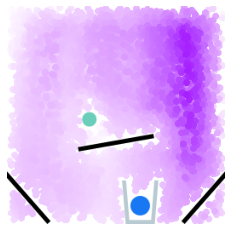

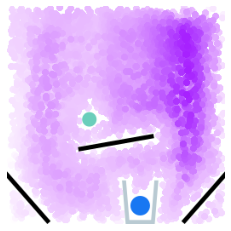

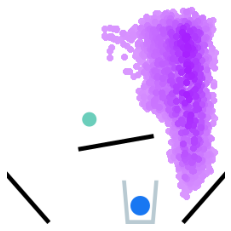

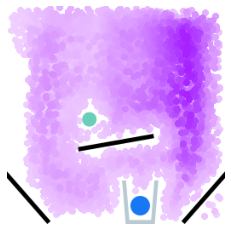

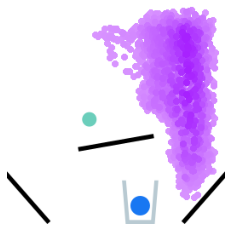

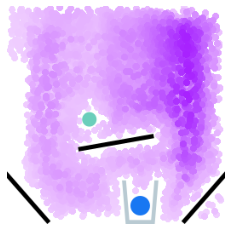

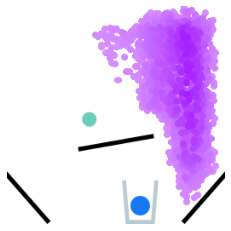

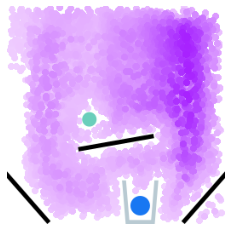

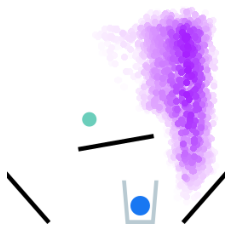

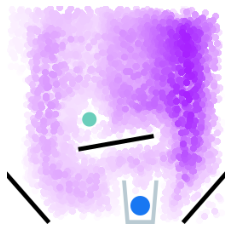

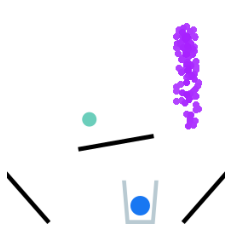

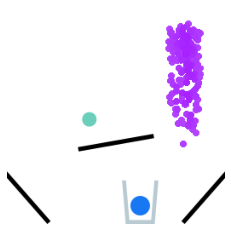

In [26]:
!mkdir action_embedding_sim

task_indices = [0, 0, 1, 1]

thresholds = [-1, 0.5, 0.7, 0.8, 0.9, 0.98]
for threshold in thresholds:
    for i, (scores,name) in list(enumerate(zip(all_scores, all_names))):
        if i < 2:
            continue
        plt.figure()


        m_scores = scores.copy()

        mask = m_scores > threshold

        m_scores[mask] = np.log((m_scores[mask] - threshold + 0.1) / (1 - threshold ))
        
        
        m_scores[~mask] = 0.001
        if threshold < 0:
            dont_plot_threshold = -np.inf
        else:
            dont_plot_threshold = 0.01

        overlay = get_policy_overlay( valid_actions, m_scores, vary_intensity=True, 
                                         threshold=dont_plot_threshold, sigmoid=False, rescale=True, end_color=[167, 33, 255])
        img = combine_visualizations(smooth_initial_scenes[_sim.task_ids[task_indices[i]]], overlay)
        plt.imshow(img, interpolation="antialiased")
        #plt.title(str(threshold) + ","+name)
        plt.axis("off")
        
        try:
            os.mkdir("action_embedding_sim/threshold_%.2f" % threshold)
        except FileExistsError:
            pass
        imageio.imwrite("action_embedding_sim/threshold_%.2f/%s.png" % (threshold, name), img)
        
       # imageio.imwrite("/checkpoint/ekahmed/gt.png",img)


In [ ]:
!tar -cvf action_emb_sim.tar action_embedding_sim/ --no-auto-compress
!python -m http.server 30303

In [ ]:
task_indices = [0, 0, 1, 1]

from scipy import signal

def gkern(kernlen=21, std=3):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

from scipy.signal import convolve2d

def merge_overlays(overlays_dict):
    return 
    thresholds = list(overlays_dict.keys())
    thresholds.sort(reverse=True)
    initial = 255 - overlays_dict[thresholds[0]].copy()
    for t in thresholds[1:]:
        current = 255 - overlays_dict[t]
        is_non_zero = current.sum(axis=2) > 0
        initial[is_non_zero] = current[is_non_zero]
    return 255 - initial

for i, (scores,name) in list(enumerate(zip(all_scores, all_names))):
    if i < 2:
        continue
    plt.figure()



    overlays_dict = {}
    end_colors = [[255, 0, 0],
                   [0, 255, 0],
                    [0, 0, 255]]
    threshold = [-1, 0.9, 0.98]
    for end_color, threshold in zip(end_colors, threshold):
        m_scores = scores.copy()
        mask = m_scores > threshold
        m_scores[mask] = np.log((m_scores[mask] - threshold + 0.1) / (1 - threshold ))


        if threshold < 0:
            dont_plot_threshold = -np.inf
        else:
            dont_plot_threshold = 0.01

        overlays_dict[threshold] = get_policy_overlay( valid_actions, m_scores, vary_intensity=True, 
                                         threshold=dont_plot_threshold, sigmoid=False,
                                     rescale=True, end_color=end_color, end_color_offset=-30,
                                                     end_color_scale=1)

    overlay = merge_overlays(overlays_dict)
    kern = np.array([[0.3, 0.7 , 0.3],
                     [0.7, 1.1 , 0.7],
                     [0.3, 0.7 , 0.3],
                    ])
    kern /= kern.sum()

    #for i in range(3):
    #    overlay[:, :, i] = convolve2d(overlay[:, :, i], kern, mode="same", boundary="symm")
    #    overlay[:, :, i] = convolve2d(overlay[:, :, i], kern, mode="same", boundary="symm")
        #overlay[:, :, i] = convolve2d(overlay[:, :, i], kern, mode="same", boundary="symm")

    #overlay = gaussian_filter(overlay, sigma=3)
    initial_scene = phyre.observations_to_uint8_rgb(_sim.initial_scenes[1])
    img = combine_visualizations(initial_scene, overlay)
    plt.imshow(img, interpolation="antialiased")
   # plt.title(str(threshold))
    plt.axis("off")

#         try:
#             os.mkdir("action_embedding_sim/threshold_%.2f" % threshold)
#         except FileExistsError:
#             pass
#         imageio.imwrite("action_embedding_sim/threshold_%.2f/%s.png" % (threshold, name), img)
        
#         #imageio.imwrite("/checkpoint/ekahmed/gt.png",img)


In [ ]:
(overlays_dict[0.9].sum(axis=2) == 0).astype(int).sum()


In [ ]:
plt.imshow(255- sum(overlays_dict.values()) // 3)

In [ ]:
thresholds = [-1]
def combine_overlays(overlay_dict):
    final = overlay_dict[-1].copy()
    for overlay_t in [0.9, 0.98]:
        mask = ~(overlay_dict[overlay_t]>0).any(axis=2)
        final[mask] = overlay_dict[overlay_t][mask]
    return final
overlay = combine_overlays(overlays_dict)
initial_scene = phyre.observations_to_uint8_rgb(_sim.initial_scenes[1])
img = combine_visualizations(initial_scene, overlay)
plt.imshow(img, interpolation="antialiased")
# plt.title(str(threshold))
plt.axis("off")


In [ ]:
overlays_dict[0.98]

In [ ]:

task_indices = [0, 0, 1, 1]

thresholds = [-1, 0.5, 0.7, 0.8, 0.9, 0.98]
for threshold in thresholds:
    for i, (scores,name) in list(enumerate(zip(all_scores, all_names))):
        if i < 2:
            continue
        plt.figure()


        m_scores = scores.copy()

        mask = m_scores > threshold

        m_scores[mask] = np.log((m_scores[mask] - threshold + 0.1) / (1 - threshold ))
        
        
        m_scores[~mask] = 0.001
        if threshold < 0:
            dont_plot_threshold = -np.inf
        else:
            dont_plot_threshold = 0.01

        img = visualize_policy(_sim, task_indices[i], valid_actions, m_scores, vary_intensity=True, 
                                         threshold=dont_plot_threshold, sigmoid=False, rescale=True, end_color=[167, 33, 255])

        plt.imshow(img, interpolation="antialiased")
       # plt.title(str(threshold))
        #plt.axis("off")
        
        try:
            os.mkdir("action_embedding_sim/threshold_%.2f" % threshold)
        except FileExistsError:
            pass
        imageio.imwrite("action_embedding_sim/threshold_%.2f/%s.png" % (threshold, name), img)
        
        #imageio.imwrite("/checkpoint/ekahmed/gt.png",img)

In [ ]:
!tar -cvf action_emb_sim.tar action_embedding_sim

In [ ]:
#!python -m http.server 30303
# use the server to download the tarball

# Episode Length vs $\Delta$ AUCCESS

In [ ]:
from collections import defaultdict
from itertools import chain
import scipy.stats
import seaborn as sns

In [ ]:
import glob
def get_per_template_results(glob_path):
    dirs =  glob.glob(glob_path)
    results = defaultdict(lambda:[]) 
    counts = defaultdict(lambda: 0)
    for dir_ in dirs:
        files = os.listdir(dir_)
        name = "detail_report.csv" 
        if name not in files:
            name = "detailed_results.csv"
        assert (name in files)
        with open(os.path.join(dir_, name),"r") as file_io:
            report = file_io.read()
        for line in report.split():
            line = line.split(",")
            if len(line) == 2:
                results[line[0]].append(float(line[1]))
                counts[line[0]] += 1

    results = sorted(tuple(results.items()))
    results = np.array([entry[1] for entry in results])
    return results

ours = get_per_template_results("/checkpoint/ekahmed/phyre/ablations/network/resnet18/aux_loss_1/seed_*")
baseline = get_per_template_results("/checkpoint/ekahmed/phyre/ablations/network/resnet18/aux_loss_0/seed_*")

In [ ]:
n_task_per_template = 10

task_ids = list(phyre.get_fold("ball_within_template", 0)[0])
np.random.RandomState(42).shuffle(task_ids)

templates = defaultdict(lambda :[])

for task_id in task_ids:
    template = task_id.split(":")[0]
    if len(templates[template]) < n_task_per_template:
        templates[template].append(task_id)


task_ids = sum(templates.values(), [])
task_ids.sort()

SIM_BATCH = 1500
psim = ParallelPhyreSimulator(task_ids, "ball", num_workers=15, max_len=17, max_batch_size=SIM_BATCH)
weakref.finalize(psim, psim.close)
cache = phyre.get_default_100k_cache("ball")

In [ ]:
max_n_solutions_per_task = 1000
n_solutions_per_task = {}

for task in task_ids:
    solved = cache.get_sample([task])["simulation_statuses"] == 1
    n_solutions_per_task[task] = min(solved.astype(int).sum(), max_n_solutions_per_task)


In [ ]:
plt.hist(list(n_solutions_per_task.values()), bins=10)

In [ ]:
max_n_solutions_per_task = 1000

solution_action_cache = {}
solution_rollout_cache = {}
solution_mask_cache = {}

for i, task in enumerate(task_ids):
    if (i + 1) % 25 == 0:
        print(f"{i + 1}/{len(task_ids)}")
    
    solved = cache.get_sample([task])["simulation_statuses"].squeeze() == 1
    solution_actions = cache.action_array[solved][:max_n_solutions_per_task]
    solution_action_cache[task] = solution_actions.copy()
    
    n_solutions = solution_actions.shape[0]
    statuses, _, features, masks = psim.simulate_parallel([i] * n_solutions, solution_actions,
                                                         need_images=False, need_featurized_objects=True)
    if not (statuses == 1).all():
        raise ValueError()
    
    solution_rollout_cache[task] = features.copy()
    solution_mask_cache[task] = masks.copy()
    

In [ ]:
def template_id_to_int(template_id):
    while template_id[0] == "0" and len(template_id) > 1:
        template_id = template_id[1:]
    return int(template_id)

def aggregate_task_metric_to_template(metric_dict):
    template_agg = defaultdict(lambda :[])
    for task_id, value in metric_dict.items():
        template = task_id.split(":")[0]
        template_agg[template].append(value)
    return {template_id_to_int(key): np.array(value) for key, value in template_agg.items()}

def average_and_flatten(dictionary):
    dictionary = {key: value.mean() for key, value in dictionary.items()}
    flattened = sorted(tuple(dictionary.items()))
    return np.array([x[1] for x in flattened])

def regplot_with_r(x, y, title_with_r=True):
    sns.regplot(x, y)
    if title_with_r:
        r,p = scipy.stats.pearsonr(x, y)
        plt.title("r=%.2f  p=%.2e" %(r, p))

In [ ]:
deltas = (ours - baseline).mean(axis=1)
agg_n_solutions = aggregate_task_metric_to_template(n_solutions_per_task)
n_sol_arr = average_and_flatten(agg_n_solutions)
regplot_with_r(n_sol_arr, deltas, title_with_r=True)

In [ ]:
deltas = (ours - baseline).mean(axis=1)

solution_length_per_task = {}
for task_id, mask_arr in solution_mask_cache.items():
    solution_lengths = mask_arr.shape[1] - mask_arr.sum(axis=1)
    solution_length_per_task[task_id] = solution_lengths.mean()
    

solution_length_agg = aggregate_task_metric_to_template(solution_length_per_task)
solution_length_arr = average_and_flatten(solution_length_agg)
regplot_with_r(solution_length_arr, deltas)
plt.xlabel("Avg Solution Length")
plt.ylabel("$\Delta$ AUCCESS")

In [ ]:
def total_dist_moved(rollouts, masks):
    #return rollouts.shape, masks.shape
    coords = rollouts[...,:2]
    coords_t = coords[:, 1:, :, :]
    coords_t_plus_1 = coords[:, :-1, :, :]
    
    dists = ((coords_t - coords_t_plus_1) ** 2).sum(axis=3) ** 0.5
    dists = dists.sum(axis=2)
    
    masks_t_plus_1 = masks[:, :-1].astype(bool)
    dists[masks_t_plus_1] = 0
    
    return dists.sum(axis=1)


total_solution_distance_per_task = {}
for task_id, mask_arr in solution_mask_cache.items():
    rollout_arr = solution_rollout_cache[task_id]
    
    avg_total_sol_dist = total_dist_moved(rollout_arr, mask_arr).mean()
    total_solution_distance_per_task[task_id] = avg_total_sol_dist

dist_moved_agg = aggregate_task_metric_to_template(total_solution_distance_per_task)
dist_moved_arr = average_and_flatten(dist_moved_agg)
regplot_with_r(dist_moved_arr, deltas)
plt.xlabel("Avg Solution Total Motion")
plt.ylabel("$\Delta$ AUCCESS")
pass

In [ ]:
EPS = 0.0001
import torch

def total_object_touches(rollouts, masks):
    masks = torch.from_numpy(masks).bool()
    rollouts = torch.from_numpy(rollouts).cuda()
    
    max_n_obj = rollouts.shape[2]
    
    coords = rollouts[..., :2]
    all_dists = ((coords[:, :, None, :, :] - coords[:, :, :, None, :]) ** 2).sum(axis=4) ** 0.5
    
   
    radii = rollouts[..., 3] / 2
    
    sum_radii = radii[:, :, None, :] + radii[:, :, :, None]
    
    valid_objs = (rollouts[...,4:8] > 0).any(dim=3)
    valid_objs = valid_objs[:, :, None, :] & valid_objs[:, :, :, None]

    are_touching = (all_dists < (sum_radii + EPS)) & valid_objs
    are_touching = are_touching.float()
    are_touching[:, :,np.arange(max_n_obj), np.arange(max_n_obj)] = 0
    
    are_touching = are_touching.sum(dim=3).sum(dim=2)    

    are_touching[masks] = 0
    
    return are_touching.mean(dim=1).cpu().detach().numpy()
    


touches_per_task = {}
for i, (task_id, mask_arr) in enumerate(solution_mask_cache.items()):
    if (i+1) % 20 == 0:
        print(f"{i+1}/250")
    rollout_arr = solution_rollout_cache[task_id]
    
    avg_touches = total_object_touches(rollout_arr, mask_arr).mean()
    touches_per_task[task_id] = avg_touches

deltas = (ours - baseline).mean(axis=1)
touches_agg = aggregate_task_metric_to_template(touches_per_task)
touches_arr = average_and_flatten(touches_agg)
regplot_with_r(touches_arr, deltas)

plt.xlabel("Avg #Touches in Solution")
plt.ylabel("$\Delta$ AUCCESS")
pass



In [ ]:
touches_arr.max()

In [ ]:
#t     : a     b     c     d     e
#t + 1 :       a     b     c     d     e
#diffs         b-a   c-b   d-c   e-d

np.arange(0, 11)[:-1]

In [ ]:
addition_tasks = list(phyre.get_fold("ball_within_template", 0)[1])
np.random.RandomState(42).shuffle(addition_tasks)
#task_ids = ["00022:660", "00022:875", "00017:013", "00000:000", "00010:490", "00022:208"] + addition_tasks[:8]
#task_ids = ["00014:585"]

sim = phyre.initialize_simulator(task_ids, "ball")
SIM_BATCH = 1200
psim = ParallelPhyreSimulator(task_ids, "ball", num_workers=10, max_len=17, max_batch_size=SIM_BATCH)
weakref.finalize(psim, psim.close)

cache = phyre.get_default_100k_cache("ball")
data = cache.get_sample(task_ids)
n_actions = 10_000
actions = cache.action_array[:n_actions]


In [ ]:
n_actions = 1000
embeddings_cache = {}
action_inds_cache = {}
for index in range(len(sim.task_ids)):
    actions_subset, action_indices = get_valid_actions(sim, cache, index, n_actions)
    labels = cache.get_sample([sim.task_ids[index]])["simulation_statuses"].squeeze()[action_indices]
    embeddings_cache[index] = get_embeddings(sim.initial_scenes[index], actions_subset, ours, baseline)
    action_inds_cache[index] = action_indices


In [ ]:
rollout_cache = {}

#logging.getLogger().setLevel(logging.WARNING)
for index, task_id in enumerate(sim.task_ids):
    valid_actions = cache.action_array[action_inds_cache[index]]
    n_actions = valid_actions.shape[0]
    rollouts = []
    masks = []
    for i in range(0, n_actions, SIM_BATCH):
        actions_batch = valid_actions[i: i + SIM_BATCH]
        _, _, r, m = psim.simulate_parallel([index] * actions_batch.shape[0], 
                                            actions_batch, 
                                            need_featurized_objects=True,
                                            need_images=False)
        rollouts.append(r.copy())
        masks.append(m.copy())
    masks = np.concatenate(masks).copy()
    rollouts = np.concatenate(rollouts).copy()
    rollout_cache[index] = rollouts, masks

    

In [ ]:
def color_final_x(rollouts, masks, color="red"):
    res = []
    for rollout,mask in zip(rollouts, masks):
        final_frame_ind = mask.size - mask.astype(int).sum() - 1
        #print(final_frame_ind, end=" ")
        final_frame = rollout[final_frame_ind]
        if color == "red":
            color_ind = 8
        elif color == "green":
            color_ind = 9
        object_ind = (final_frame[:, color_ind] >0.5).argmax()
        res.append(final_frame[object_ind, 0])
    return np.array(res)
print(sim.simulate_action(0, cache.action_array[action_inds_cache[0][0]], 
                          need_featurized_objects=True).featurized_objects.features[-1][0])
#rollout_cache[0][0][0]
#color_final_x(*rollout_cache[ind], color="green")
#np.allclose(psim.simulate_parallel([0], actions[0], need_featurized_objects=True)[2][0,:, :6, :],
#sim.simulate_action(0, actions[0], need_featurized_objects=True).featurized_objects.features[:17])

In [ ]:
min_dist_cache = {}
for index, _ in enumerate(sim.task_ids):
    rollouts, masks = rollout_cache[index]
    min_dists = batched_min_dist(rollouts, masks)
    min_dist_cache[index] = min_dists

In [ ]:
index = 0
for index, _ in enumerate(sim.task_ids[:1]):
    color_by = cache.get_sample([sim.task_ids[index]])["simulation_statuses"].squeeze()[action_inds_cache[index]]
    #color_by = min_dist_cache[index]
    plt.figure(figsize=(20,10))
    plt.gcf().suptitle(str((color_by[:1000]==1).sum()))
    tsne_comparison(embeddings_cache[index], ["ours", "baseline"], color_by, n_points=1000, perplexity=30)

In [ ]:
for ind in [0]:
    color_by = color_final_x(*rollout_cache[ind], color="green")
    print(color_by.min())
    #color_by = min_dist_cache[ind]
    plt.figure(figsize=(20,10))
    tsne_comparison(embeddings_cache[ind], ["ours", "baseline"], color_by, n_points=1000, perplexity=30)

In [ ]:
colo

In [ ]:
psim.simulate_parallel??

In [ ]:
min_dists
labels

In [ ]:
cache.get_sample([sim.task_ids[0]])["simulation_statuses"].squeeze()[action_inds_cache[0]][]

In [ ]:
for index in range(5):
    labels = cache.get_sample([sim.task_ids[index]])["simulation_statuses"].squeeze()[action_inds_cache[index]][:1000]
    min_ds = min_dist_cache[index]
    plt.figure()
    plt.scatter(labels, min_ds)

In [ ]:

imgs = []

for i, task_id in enumerate(task_ids_):
    action_solved_mask = cache.get_sample([task_id])["simulation_statuses"][0, :10000] ==1
    solution_actions = cache.action_array[:10_000][action_solved_mask]
    scores = np.ones(solutions.shape[0])
    imgs.append(visualize_policy(_sim, i, solution_actions, scores, vary_intensity=False))


import imageio
for img in imgs:
    plt.figure()
    plt.imshow(img, interpolation="antialiased")
    plt.axis("off")
    #imageio.imwrite("/checkpoint/ekahmed/gt.png",img)


# Fancy new vis


In [ ]:
globals().keys()

In [ ]:
import cairo
_sim._tasks[0]
